In [50]:
!pip install numpy --quiet
!pip install matplotlib --quiet
!pip install control --quiet


In [1]:
import numpy as np
import scipy 
import scipy.linalg as la
import matplotlib.pyplot as plt
import control as ctrl

In [2]:
def lqr(A, B, Q, R):
    """
    Parameters:
        A (numpy.ndarray): State matrix.
        B (numpy.ndarray): Input matrix.
        Q (numpy.ndarray): State cost matrix.
        R (numpy.ndarray): Input cost matrix.

    Returns:
        K (numpy.ndarray): Feedback gain matrix.
    """
    P = la.solve_continuous_are(A, B, Q, R)

    # Calculate the feedback gain matrix
    K = np.linalg.inv(R) @ B.T @ P
    return K

In [4]:
Xcm = 1.052
Xpe = 0.261
L = 3.304
Df = 0.127
Tlin = 230.57
Izz = 15.07
M = 23.545
g = 9.8055
dar = 1.091
Cd = 0.432
Vxlin = -10.0
Vvlin = 2.2

# X = [x,y,theta,xp,yp,thetap]
# Xp = [xp,yp,thetap,xpp,ypp,thetapp]
A = np.array([[0, 0, 0, 1],
              [(1/M)*((1/2)*dar*Cd*Vxlin**2*L*Df + (1/2)*dar*Cd*L*Df*Vvlin**2), (1/M)*(Vxlin *dar*Cd*((Df/2)**2*np.pi)), 0, 0],
              [(1/M)*(-M*g+(1/2)*Vxlin**2*dar*Cd*(np.pi*(Df/2)**2) - (1/2)*dar*Cd*(np.pi*(Df/2)**2)*Vvlin**2), 0, 0, 0],
              [(1/Izz)*((1/2)*Vxlin**2*dar*Xpe*Cd*(np.pi*(Df/2)**2)- (1/2)*dar*Cd*Xpe*(np.pi*(Df/2)**2)*Vvlin**2), 0, 0, 0]])

# u = [T,tau,Vv]

B = np.array([[0, 0, 0],
              [1/M, 0, 0],
              [0, -Tlin/M, - (1/2)*dar*Cd*L*Df*2*Vvlin/M],
              [0, -Tlin*Xcm/Izz, - (1/2)*dar*Cd*Xpe*L*Df*2*Vvlin/Izz]])
# Matriz B com perturbação, para pegar as funções transferência

#Para pegar a contrabilidade a B e a E são separadas

Bcont = np.array([[0, 0],
              [1/M, 0],
              [0, -Tlin/M],
              [0, -Tlin*Xcm/Izz]])

E = np.array([[0],
              [0],
              [ - (1/2)*dar*Cd*L*Df*2*Vvlin],
              [- (1/2)*dar*Cd*Xpe*L*Df*2*Vvlin]])

C = np.array([[ 0, 1, 0, 0],
              [ 0, 0, 1, 0]])

D = np.array([[ 0, 0,0],
              [ 0, 0,0]])


In [11]:
# Primeiro passo é calcular o L, para isso vou criar um sistema com A transposto e C transposto no lugar do B

p = [-1 ,  -0.5 - 0.24j,  -0.5 + 0.24j ,-2 ]

#p = [-2.5,-2.5, -3,-1]

# Calculate the gain matrix K using pole placement
Kbun = scipy.signal.place_poles(A.T, C.T, p, method='YT')
Kobs = Kbun.gain_matrix

L = Kobs.T
print(L)

[[ 0.07837575 -0.2327481 ]
 [ 1.01660346 -0.08997573]
 [-0.43683567  2.98086078]
 [ 0.01647193 -0.06363041]]


In [7]:
#Pegando o K do meu sistema com LQR

Q = np.diag([1, 10, 1,1])          # don't turn too sharply
R = np.diag([0.1, 150])  

Klqr = lqr(A,Bcont, Q, R)

print(Klqr)

[[ 0.54561999  9.89610431  0.29755796 -0.0848724 ]
 [-0.78304625 -0.02429594  0.08128739 -0.37568957]]


In [14]:
#Para a simulação do observador, tenho que expandir meu vetor variável de estado, a fim de acrescentar o Erro

Acl = A - np.dot(Bcont, Klqr)

A_chap = A - np.dot(L, C)

Aobs = np.block([[Acl, np.dot(Bcont,Klqr)],
                [np.zeros_like(A), A_chap]])
Bobs = np.block([[B], [np.zeros_like(B)]])
Cobs = np.eye(Aobs.shape[0])
Dobs = np.zeros((Aobs.shape[0], Bobs.shape[1]))

print("Novo A =",Aobs)
print("\n")
print("Novo B =",Bobs)
print("\n")
print("Novo C =",Cobs)
print("\n")
print("Novo D =",Dobs)

Novo A = [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 4.17128422e-01 -4.22841735e-01 -1.26378405e-02  3.60468887e-03
   2.31734971e-02  4.20305981e-01  1.26378405e-02 -3.60468887e-03]
 [-1.74616011e+01 -2.37923742e-01  7.96026041e-01 -3.67902929e+00
   7.66816624e+00  2.37923742e-01 -7.96026041e-01  3.67902929e+00]
 [-1.25986247e+01 -3.91056009e-01  1.30836361e+00 -6.04692285e+00
   1.26035446e+01  3.91056009e-01 -1.30836361e+00  6.04692285e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -7.83757459e-02  2.32748104e-01  1.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.40301920e-01 -1.01913922e+00  8.99757262e-02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -9.79343488e+00  4.36835665e-01 -2.98086078e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.0000000

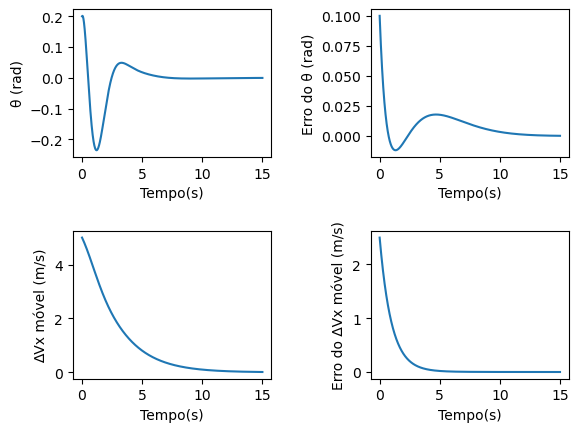

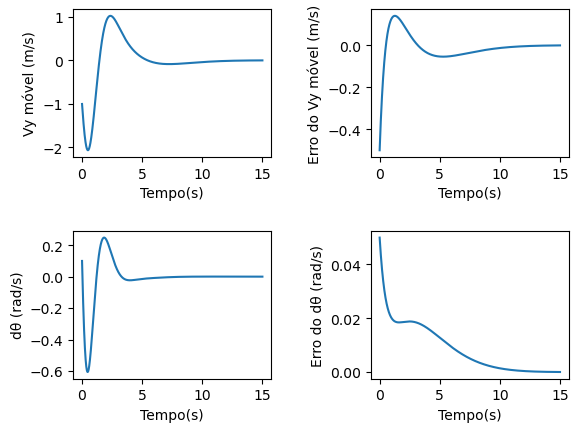

In [56]:
# Com o novo sistema, basta realizar as simulações

sysobs = ctrl.ss(Aobs,np.block([[E], [np.zeros_like(E)]]), Cobs, 0)

tempo = np.linspace(0, 15, 400000)
e0 = 50 #em % do valor inicial respectivo
X0_x = [0.2, 5, -1, 0.1] #Valores iniciais dos estados 
X0  = [X0_x[0], X0_x[1], X0_x[2], X0_x[3],X0_x[0] * e0/100,X0_x[1] * e0/100 ,X0_x[2] * e0/100,X0_x[3] * e0/100]

t, amp,yobs = ctrl.forced_response(sysobs, tempo, 0 ,X0 ,return_x = 'True')

f,((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2)
plt.subplots_adjust( wspace=0.5,hspace=0.5)
f,((ax5, ax6), (ax7,ax8)) = plt.subplots(2, 2)
plt.subplots_adjust( wspace=0.5,hspace=0.5)
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
ax3.set_xlabel('Tempo(s)')
ax4.set_xlabel('Tempo(s)')
ax5.set_xlabel('Tempo(s)')
ax6.set_xlabel('Tempo(s)')
ax7.set_xlabel('Tempo(s)')
ax8.set_xlabel('Tempo(s)')

ax1.plot(t, yobs[0])
ax1.set_ylabel('θ (rad)')

ax2.plot(t, yobs[4])
ax2.set_ylabel('Erro do θ (rad)')

ax3.plot(t, yobs[1])
ax3.set_ylabel('∆Vx móvel (m/s)')

ax4.plot(t, yobs[5])
ax4.set_ylabel('Erro do ∆Vx móvel (m/s)')

ax5.plot(t, yobs[2])
ax5.set_ylabel('Vy móvel (m/s)')

ax6.plot(t, yobs[6])
ax6.set_ylabel('Erro do Vy móvel (m/s)')

ax7.plot(t, yobs[3])
ax7.set_ylabel('dθ (rad/s)')

ax8.plot(t, yobs[7])
ax8.set_ylabel('Erro do dθ (rad/s)')
plt.show(block=False)

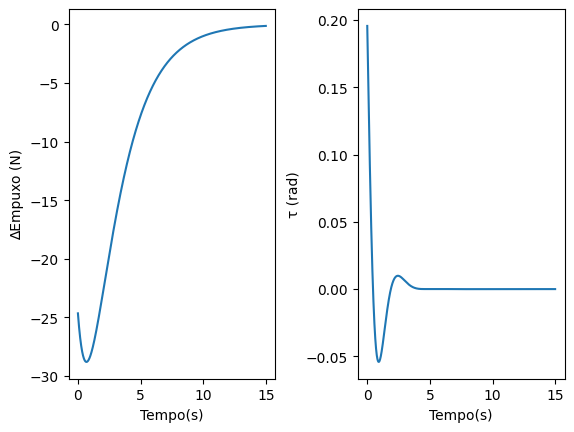

In [58]:
uobs = np.dot(-Klqr,[yobs[0]-yobs[4],yobs[1]-yobs[5],yobs[2]-yobs[6],yobs[3]-yobs[7]])
f,(ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4,hspace=0.5)
ax1.plot(t, uobs[0])
ax1.set_ylabel('∆Empuxo (N)')

ax2.plot(t, uobs[1])
ax2.set_ylabel('τ (rad)')
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
plt.show(block=False)

In [28]:
np.zeros((8,1))

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [57]:
#Para a implementação do seguidor de referencia será realizada outra expansão do sistema, a fim de implementar o xr nas variáveis de estado e em A


Klqr2 = np.block([[Klqr,np.zeros_like(Klqr)]])

Q2 = np.diag([1, 10, 1,1,1,10,1,1])         
R2 = np.diag([0.1, 150])  

B2 = np.block([[Bcont], [np.zeros_like(Bcont)]])
B1 = np.block([[E], [np.zeros_like(E)]])

#M = lqr(Aobs,Bobs, Q2, R2)

M = np.block([[0,1,0,0,0,0,0,0],[0,0,1,0,0,0,0,0]]) #tem que ser u.shape por x.shape
w = 2
z = 0.5
#Ar = -1*np.eye(8)
Ar = np.array([[0, 0, 0, 1, 0, 0, 0, 0], [0, -1, 0, 0, 0, 0, 0, 0], [0, 0, -1, 0, 0, 0, 0, 0], [-w ** 2, 0,0, -2 * z * w, 0, 0, 0, 0],[0, 0, 0, 0, -1, 0, 0, 0],[0, 0, 0, 0, 0, -1, 0, 0],[0, 0, 0, 0, 0, 0, -1, 0],[0, 0, 0, 0, 0, 0, 0, -1]])
Aw = np.array([-1])
F = np.block([B1,(Aobs - Ar)])
Ao = np.block([[Aw,np.zeros((1,8))],[np.zeros((8,1)),Ar]])

A_cl_inv = np.linalg.inv(Aobs - B2 @ Klqr2)

N = np.linalg.inv(M @ A_cl_inv @ B2) @ M @ A_cl_inv
Gr = N @ F

#Calculando aos poucos o Kex
Kex = np.linalg.inv(M @ A_cl_inv @ B2) @ M @ A_cl_inv @ F



#Kex2 = np.block([[-Gr, Klqr2 - Gr]])    

print("Kex =",Kex)

print()

#print("Kex2 =",Kex2)


Atot = np.block ([[Aobs - np.dot(B2,Klqr2), np.block([B1, np.dot(B2,Klqr2)]) - np.dot(B2, Kex)], [np.zeros((9,8)), Ao ]])

#Atot = np.block([[Aobs - Bobs @ Gr, Bobs @ (Klqr2 - Gr)], 
#                    [Ar - Aobs + Bobs @ Gr, Ar - Bobs @ (Klqr2 - G_r)]])

Btot = np.block([[Bobs], [np.zeros_like(Bobs)]])
Ctot = np.block([C, np.zeros((2,13))])
Dtot = np.zeros((Atot.shape[0], Btot.shape[1]))

print("Atot = ",Atot)
print()
print("Btot = ",Btot)
print()
print("Ctot = ",Ctot)
print()
print("Dtot = ",Dtot)
print()

Kex = [[-0.34654033 -1.75866546 13.58919136  0.64928395 -1.06727033  0.0848724
   9.84486494  0.50060976  4.54401091]
 [-0.05144281 -1.42053924  0.02429594  0.07854503  0.05694308  0.37568957
   0.01761613 -0.08244926 -6.5390623 ]]

Atot =  [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.93954925e-01 -8.43147715e-01 -2.52756811e-02  7.20937774e-03
   2.31734971e-02  4.20305981e-01  1.26378405e-02 -3.60468887e-03
   1.47182130e-02  9.78672945e-02 -1.56852285e-01 -1.49384578e-02
   4.17242695e-02 -3.60468887e-03 -4.18129749e-01 -2.12618287e-02
  -1.92992606e-01]
 [-2.51297674e+01 -4.75847484e-01  1.59205208e+00 -7.35805857e+00
   7.66816624e+00  2.37923742e-01 -7.96026041e-01  3.67902929e+00
  -9.38851746e-01 -6.24280136e+00  4.75847484e-01 -2.68551769

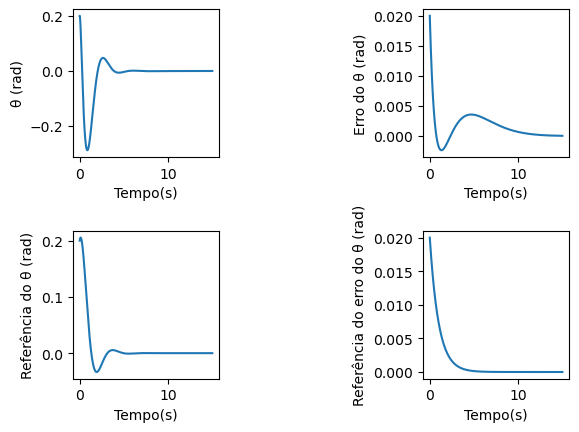

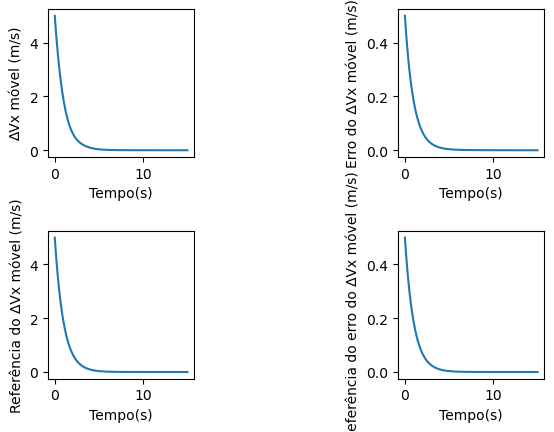

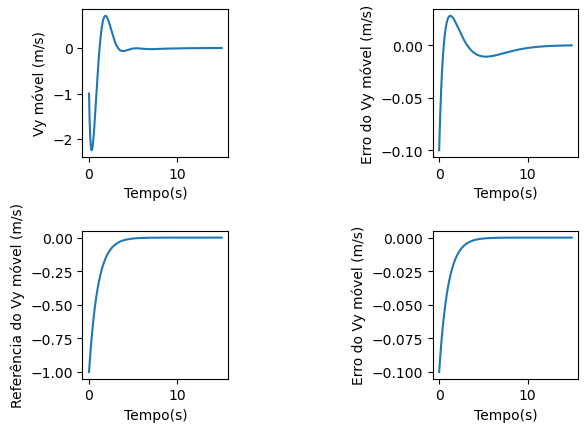

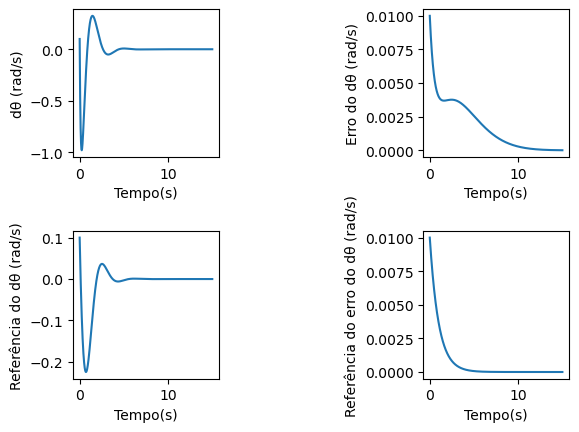

In [58]:
# Com o novo sistema, basta realizar as simulações
B1tot = np.block([[B1],[np.zeros((9,1))]])
systot = ctrl.ss(Atot, B1tot, Ctot, 0)
#systot = ctrl.ss(Atot, np.zeros((16,2)), Kex, 0)

tempo = np.linspace(0, 15, 400000)
e0 = 10 #em % do valor inicial respectivo
r = 100
rvento = 3
X0_x = [0.2, 5, -1, 0.1] #Valores iniciais dos estados 
X0  = np.array([X0_x[0], X0_x[1], X0_x[2], X0_x[3],X0_x[0] * e0/100,X0_x[1] * e0/100 ,X0_x[2] * e0/100,X0_x[3] * e0/100])

X0 = np.block([X0,rvento ,r/100*X0])

t, amp,ytot = ctrl.forced_response(systot, tempo, 0 ,X0 ,return_x = 'True')
# t, u, x = ctrl.forced_response(systot, U=0, T=tempo, X0=X0, return_x=True)
# ytot = x


f,((ax1, ax2),(ax9,ax10)) = plt.subplots(2, 2)
plt.subplots_adjust(wspace=1.4,hspace=0.5)
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
ax9.set_xlabel('Tempo(s)')
ax10.set_xlabel('Tempo(s)')


ax1.plot(t, ytot[0])
ax1.set_ylabel('θ (rad)')

ax2.plot(t, ytot[4])
ax2.set_ylabel('Erro do θ (rad)')

ax9.plot(t, ytot[9])
ax9.set_ylabel('Referência do θ (rad)')

ax10.plot(t, ytot[13])
ax10.set_ylabel('Referência do erro do θ (rad)')

f,((ax3,ax4),(ax11,ax12)) = plt.subplots(2, 2)
plt.subplots_adjust(wspace=1.4,hspace=0.5)
ax3.set_xlabel('Tempo(s)')
ax4.set_xlabel('Tempo(s)')
ax11.set_xlabel('Tempo(s)')
ax12.set_xlabel('Tempo(s)')

ax3.plot(t, ytot[1])
ax3.set_ylabel('∆Vx móvel (m/s)')

ax4.plot(t, ytot[5])
ax4.set_ylabel('Erro do ∆Vx móvel (m/s)')

ax11.plot(t, ytot[10])
ax11.set_ylabel('Referência do ∆Vx móvel (m/s)')

ax12.plot(t, ytot[14])
ax12.set_ylabel('Referência do erro do ∆Vx móvel (m/s)')

f,((ax5, ax6),(ax13,ax14)) = plt.subplots(2, 2)
plt.subplots_adjust(wspace=1.4,hspace=0.5)

ax5.set_xlabel('Tempo(s)')
ax6.set_xlabel('Tempo(s)')
ax13.set_xlabel('Tempo(s)')
ax14.set_xlabel('Tempo(s)')

ax5.plot(t, ytot[2])
ax5.set_ylabel('Vy móvel (m/s)')

ax6.plot(t, ytot[6])
ax6.set_ylabel('Erro do Vy móvel (m/s)')

ax13.plot(t, ytot[11])
ax13.set_ylabel('Referência do Vy móvel (m/s)')

ax14.plot(t, ytot[15])
ax14.set_ylabel('Erro do Vy móvel (m/s)')

f,((ax7,ax8),(ax15,ax16)) = plt.subplots(2, 2)
plt.subplots_adjust( wspace=1.4,hspace=0.5)

ax7.set_xlabel('Tempo(s)')
ax8.set_xlabel('Tempo(s)')
ax15.set_xlabel('Tempo(s)')
ax16.set_xlabel('Tempo(s)')

ax7.plot(t, ytot[3])
ax7.set_ylabel('dθ (rad/s)')

ax8.plot(t, ytot[7])
ax8.set_ylabel('Erro do dθ (rad/s)')

ax15.plot(t, ytot[12])
ax15.set_ylabel('Referência do dθ (rad/s)')

ax16.plot(t, ytot[16])
ax16.set_ylabel('Referência do erro do dθ (rad/s)')
plt.show(block=False)

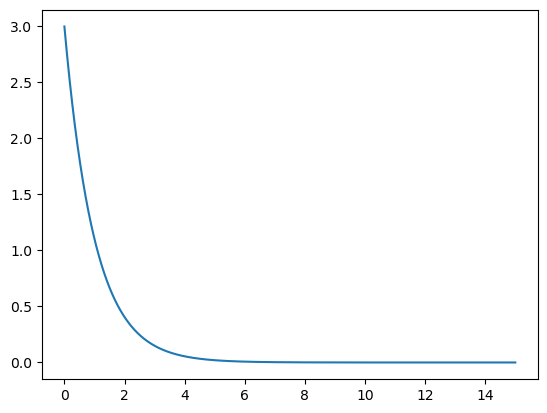

In [63]:
plt.plot(t,ytot[8])

In [48]:
ur = np.dot(Klqr2,[ytot[8]-(ytot[0]),ytot[9]-(ytot[1]),ytot[10]-(ytot[2]),ytot[11]-(ytot[3]),
                  ytot[12]-(ytot[4]),ytot[13]-(ytot[5]),ytot[14]-(ytot[6]),ytot[15]-(ytot[7])]) - np.dot(Gr,ytot[8:16])
f,(ax1, ax2) = plt.subplots(1,2)    
plt.subplots_adjust(right=0.9, wspace=0.4,hspace=0.5)
ax1.plot(t, ur[0])
ax1.set_ylabel('∆Empuxo (N)')

ax2.plot(t, ur[1])
ax2.set_ylabel('τ (rad)')
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
plt.show(block=False)

ValueError: shapes (2,9) and (8,400000) not aligned: 9 (dim 1) != 8 (dim 0)

In [62]:
Q = np.diag([1, 10, 1,1])          # don't turn too sharply
R = np.diag([0.1, 150])  

K = lqr(A,B, Q, R)
print(K)
Acl = A - np.dot(B, K)
syscl = ctrl.ss(Acl, np.zeros((4,2)), C, D)

tempo = np.linspace(0, 10, 400000)
X0  = [0.2, 5, -1, 0.1]

t, amp,yr = ctrl.forced_response(syscl, tempo, 0 ,X0,return_x = 'True')

[[ 0.52063658  9.90007058  0.28397527 -0.08099821]
 [-0.78271178 -0.0231869   0.08131977 -0.37564641]]


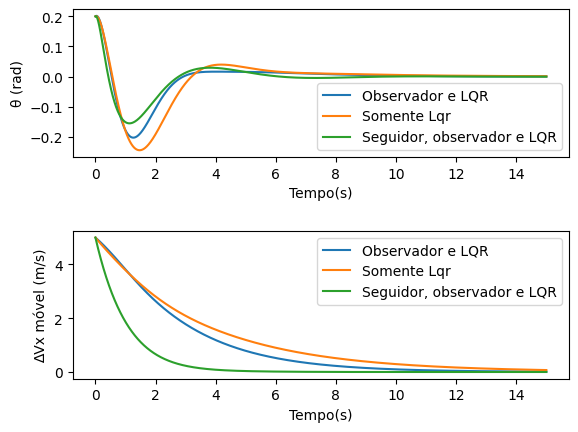

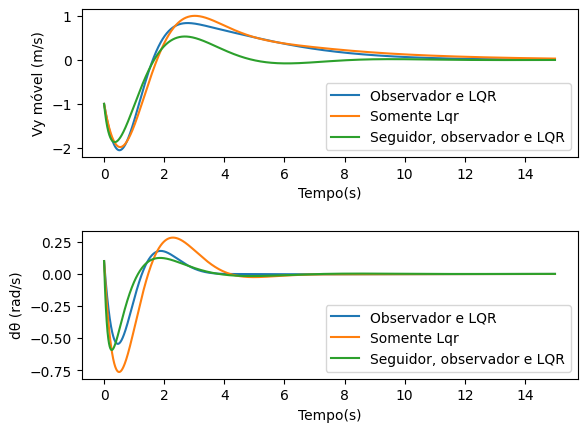

In [65]:
# Com o novo sistema, basta realizar as simulações

sysobs = ctrl.ss(Aobs, np.zeros((8,2)), Cobs, Dobs)

tempo = np.linspace(0, 15, 400000)
e0 = 50 #em % do valor inicial respectivo
X0_x = [0.2, 5, -1, 0.1] #Valores iniciais dos estados 
X0  = [X0_x[0], X0_x[1], X0_x[2], X0_x[3],X0_x[0] * e0/100,X0_x[1] * e0/100 ,X0_x[2] * e0/100,X0_x[3] * e0/100]

t, amp,yobs = ctrl.forced_response(sysobs, tempo, 0 ,X0 ,return_x = 'True')

f,((ax1,ax3)) = plt.subplots(2, 1)
plt.subplots_adjust( wspace=0.5,hspace=0.5)
f,((ax5,ax7)) = plt.subplots(2, 1)
plt.subplots_adjust( wspace=0.5,hspace=0.5)
ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
ax3.set_xlabel('Tempo(s)')
ax4.set_xlabel('Tempo(s)')
ax5.set_xlabel('Tempo(s)')
ax6.set_xlabel('Tempo(s)')
ax7.set_xlabel('Tempo(s)')
ax8.set_xlabel('Tempo(s)')

ax1.plot(t, yobs[0])
ax1.plot(t, yr[0])
ax1.plot(t, ytot[0])
ax1.legend(['Observador e LQR', 'Somente Lqr','Seguidor, observador e LQR'])
ax1.set_ylabel('θ (rad)')


ax3.plot(t, yobs[1])
ax3.plot(t, yr[1])
ax3.plot(t, ytot[1])
ax3.legend(['Observador e LQR', 'Somente Lqr','Seguidor, observador e LQR'])
ax3.set_ylabel('∆Vx móvel (m/s)')


ax5.plot(t, yobs[2])
ax5.plot(t, yr[2])
ax5.plot(t, ytot[2])
ax5.legend(['Observador e LQR', 'Somente Lqr','Seguidor, observador e LQR'])
ax5.set_ylabel('Vy móvel (m/s)')


ax7.plot(t, yobs[3])
ax7.plot(t, yr[3])
ax7.plot(t, ytot[3])
ax7.legend(['Observador e LQR', 'Somente Lqr','Seguidor, observador e LQR'])
ax7.set_ylabel('dθ (rad/s)')

plt.show(block=False)

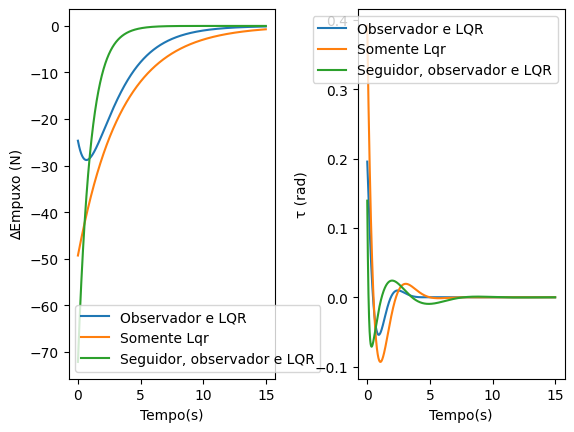

In [66]:
u = np.dot(-K,yr)
f,(ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace=0.4,hspace=0.5)
ax1.plot(t, uobs[0])
ax1.plot(t, u[0])
ax1.plot(t, ur[0])
ax1.legend(['Observador e LQR', 'Somente Lqr','Seguidor, observador e LQR'])
ax1.set_ylabel('∆Empuxo (N)')

ax2.plot(t, uobs[1])
ax2.plot(t, u[1])
ax2.plot(t, ur[1])
ax2.legend(['Observador e LQR', 'Somente Lqr','Seguidor, observador e LQR'])
ax2.set_ylabel('τ (rad)')

ax1.set_xlabel('Tempo(s)')
ax2.set_xlabel('Tempo(s)')
plt.show(block=False)